# Machine Learning Project

## Objective

The objective of this jupyter notebook, as part of the web service project, is to of to train a model using the data set provided, explain the model and give an analysis of its accuracy.

### Import libraries

In [87]:
# import neccessary libaries. Will add to as needs be.
# to plot data
import matplotlib.pyplot as plt
#to load data as a pandas df
import pandas as pd
# to convert data to a numpy array
import numpy as np

# Adapted from https://stackoverflow.com/q/43027980 [13]
# A magic function that renders the figure in a notebook (instead of displaying a dump of the figure object).
%matplotlib inline
# setting some plt parameters that are always useful
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# import seaborn for visualiaztions later.
import seaborn as sns
# using for linear regresssion
from sklearn.linear_model import LinearRegression
# using for splitting data into train & test.
from sklearn.model_selection import train_test_split
# using for linear model
from sklearn import linear_model
# using to evaluate sklearn model results.
from sklearn import metrics
#using for polynominal regression.
from sklearn.preprocessing import PolynomialFeatures
# using for keras model
import tensorflow as tf
from tensorflow import keras
# importing tf metrics
from tensorflow.python.keras.metrics import Metric
# use to save models as packages to be used in web app.
import joblib


## Load the Data

In [7]:
# reading the file in as csv.
df = pd.read_csv("https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv")
# Making a copy of the data just in case I need it later on.
dfmycopy = df

## Explore the Data

In [8]:
# take a look at the shape: #rows, colums
print("Number of rows:", df.shape[0],"\nNumber of columns: ",df.shape[1])

Number of rows: 500 
Number of columns:  2


In [9]:
# Do any  NaN (null) values exist?
df.isnull().values.any()

False

In [10]:
#take a peak at the first rows  (note to self zero values exist)
df.head()

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0


In [6]:
#take at the last rows
df.tail()

,speed,power
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0
499,25.000,0.0


In [11]:
# describe the data set. 
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


In [15]:
# just checking it is actually zero.
minwind = df['speed'].min()
import decimal
print('{:.50f}'.format(minwind))

0.00000000000000000000000000000000000000000000000000


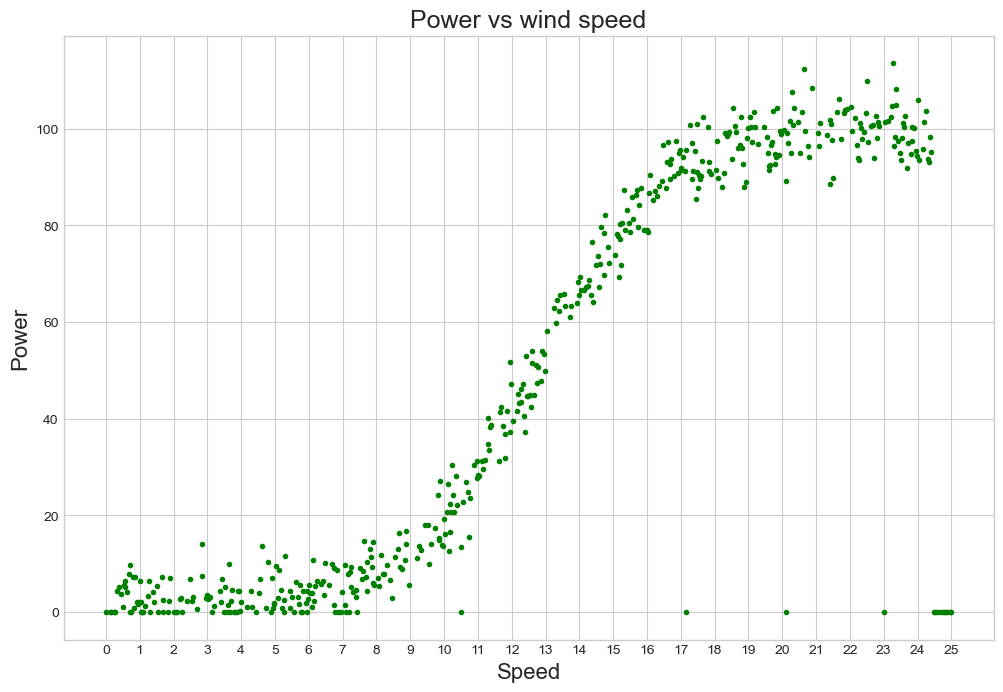

In [19]:

# Plot power versus speed to see if there is a relationship between both. 
plt.plot(df['speed'], df['power'],  '.g')
plt.title('Power vs wind speed', fontsize='18')
plt.xlabel('Speed', fontsize='16')
plt.ylabel('Power', fontsize='16')
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.show()

## Initial Visual Observations

From this visual, there appears three regions approximately. In the first region, below speeds of approximately 7.5 the power generated appears low and there does not appear a correlation to speed. One could logically speculate that below a certain speed (threshold) power is not generated (we have all seen still wind turbines) or is at least at low speed the power generated can relatively small or close to zero.

In the second regions, from speed values 7.5 to 10 there appears to be some correlation between speed and power emerging. 

In the third region, from speed values of 10 to 17.5 approx, there appears a rapid growth of power produced.  In otherwords,power generated tends to increase linearly from around speed values of 10 to 17.5. 

In the fourth region, for datapoints with speed values of 17.5 and constant power values are produced. 

But, then there are a number of datapoints with various speed values other than 0 but power produced is zero. **Also there are no speed values beyond approximately 24.5 where there is power generated. 

The below visualization separates those datapoints where power is zero from datapoints where power was actually generated.

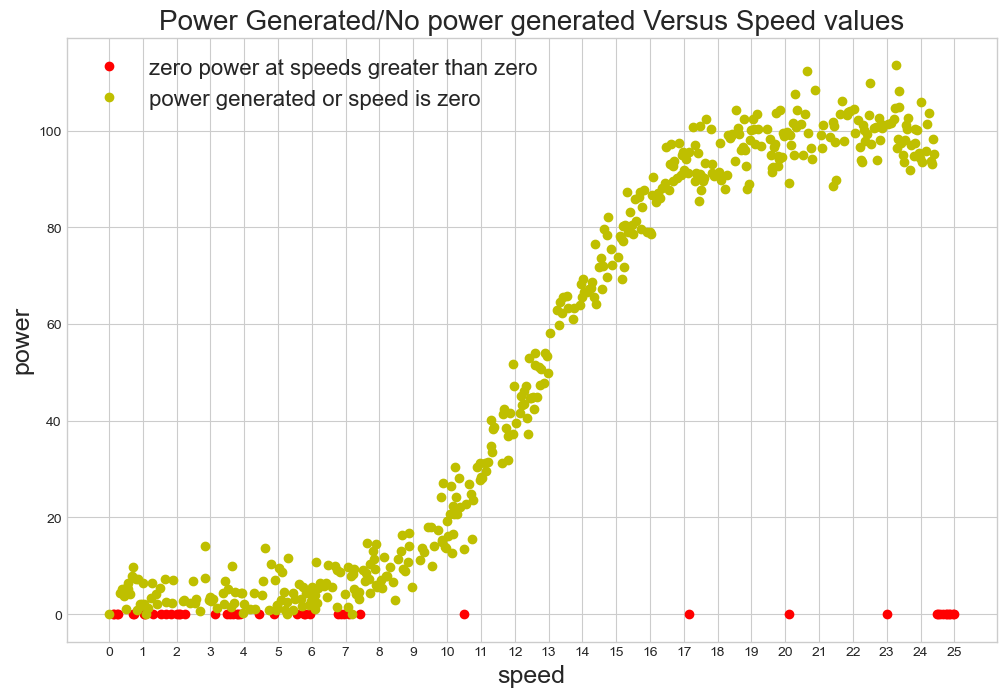

In [20]:

#Selecting rows based on certain conditions
# https://stackoverflow.com/a/17071908/11250489 [14] 
# example df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
# speed greater than zero but power less than or equal to 0
dfa= df.loc[(df['speed'] !=0) & (df['power'] == 0)]
dfb=  df.loc[((df['speed'] !=0) & (df['power'] >0))|(df['speed']==0)]
plt.plot(dfa['speed'], dfa['power'],  'ro', label='zero power at speeds greater than zero')
plt.plot(dfb['speed'], dfb['power'],  'yo', label= 'power generated or speed is zero ')
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.xlabel('speed', fontsize = 18)
plt.ylabel('power', fontsize =18)
plt.title('Power Generated/No power generated Versus Speed values', fontsize = 20)
plt.legend(fontsize = 16)
plt.show()

## Determing which datapoints to exclude from the models.

### 1. Zero power generated at speeds less than or equal to 7.5 (keep)

Before rushing into excluding all values where power is equal to zero. I think it is worth zooming in on the data where speed is less than or equal 7.5.  As the below data visualization shows there are many observations where the power generated is close to zero when speed <=7.5. In my mind these points might legitimize the existance of datapoints with zero power generated when speed <=7.5. So I am reluctant to exclude datapoints where speed <= 7.5 and power generated is zero at this stage. This is the exploratory stage in the process so this decision might well be revisited later after further investigation.

In [21]:
# examining datapoints where speed <=7.5 and power is not generated.
dfc= df.loc[(df['speed']<=7.5)& (df['power']!=0) ]
print(dfc.describe())

            speed       power
count  115.000000  115.000000
mean     4.015539    4.553670
std      2.202909    3.081373
min      0.325000    0.067000
25%      2.039500    2.126000
50%      4.304000    4.187000
75%      5.968500    6.504000
max      7.407000   14.131000


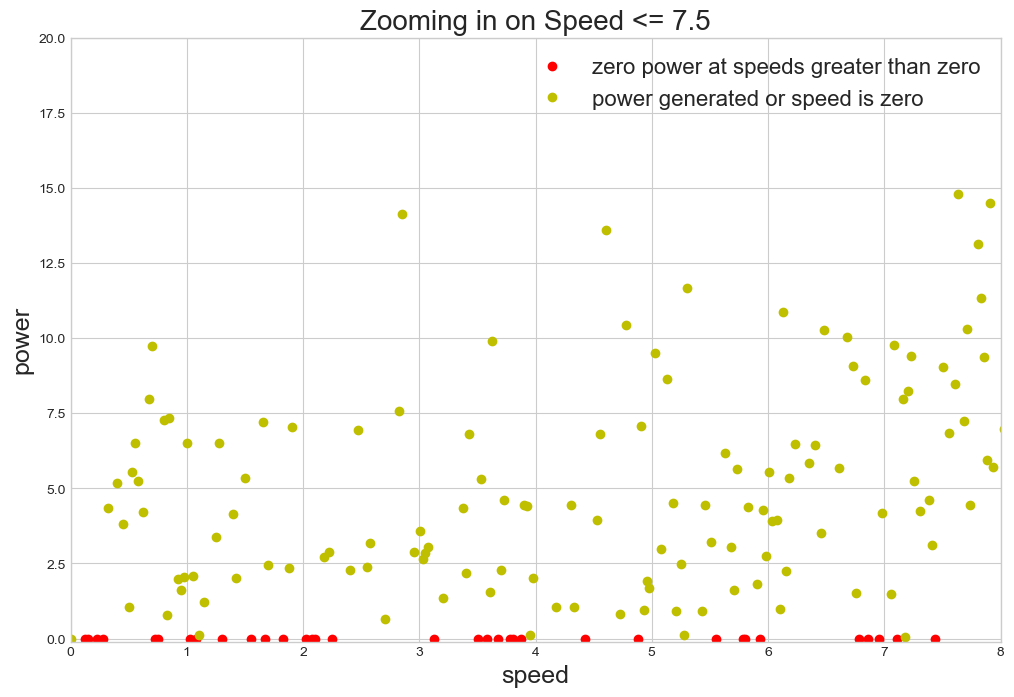

In [22]:
#Selecting rows based on certain conditions
# Adapted from https://stackoverflow.com/a/17071908 [15]
# example df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
# speed greater than zero but power less than or equal to 0
dfa= df.loc[(df['speed'] !=0) & (df['power'] == 0)]
dfb=  df.loc[((df['speed'] !=0) & (df['power'] >0))|(df['speed']==0)]
plt.plot(dfa['speed'], dfa['power'],  'ro', label='zero power at speeds greater than zero')
plt.plot(dfb['speed'], dfb['power'],  'yo', label= 'power generated or speed is zero ')
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.xlabel('speed', fontsize = 18)
plt.ylabel('power', fontsize =18)
plt.xticks(np.arange(min(df['speed']), max(df['speed'])+1, 1))
plt.title('Zooming in on Speed <= 7.5', fontsize = 20)
plt.legend(fontsize = 16)
plt.xlim(0, 8)
plt.ylim(-0.1,20)
plt.show()


### 2. Zero power generated for speeds between > 7.5 and < 24.5 (exclude)

I do think the 4 datapoints with zero power generated and with speed greater than 7.5 but less than 24.5 approxmiately are strong contenders for being dropped from the dataset.  They do seem to be outliers. Outliers are the data instances that stand out amongst other datapoints in the dataset and fail to conform to the normal behavior in a dataset [1],[2].

### 3. Zero power generated for speeds >= 24.5 (exclude)

With regards to zero power generated datapoints with speeds that are greater than 24.5, I am unsure if they should be excluded. But we need to zoom in on the datapoints where speed is greater than 24.
Looking on below figure "Zooming in on Speed <= 24" we can see that **ALL observations at speed 24.5 or greater have zero power**.  Therefore I would conclude at this stage that these observations might well be legitimate. Perhaps a wind turbine doesnt function in "high" winds. My concern is though do I have enough datapoints with speed >=24.5 so that a model will distinguish these datapoints from datapoints with speed < 24.5. Actually, I do not have a model that will accurately predict such values ( I am retro applying this learning). 

So to summarize, for the moment or until I know more, keep all datapoints with zero power except those datapoints with speed speed greater than 7.5.

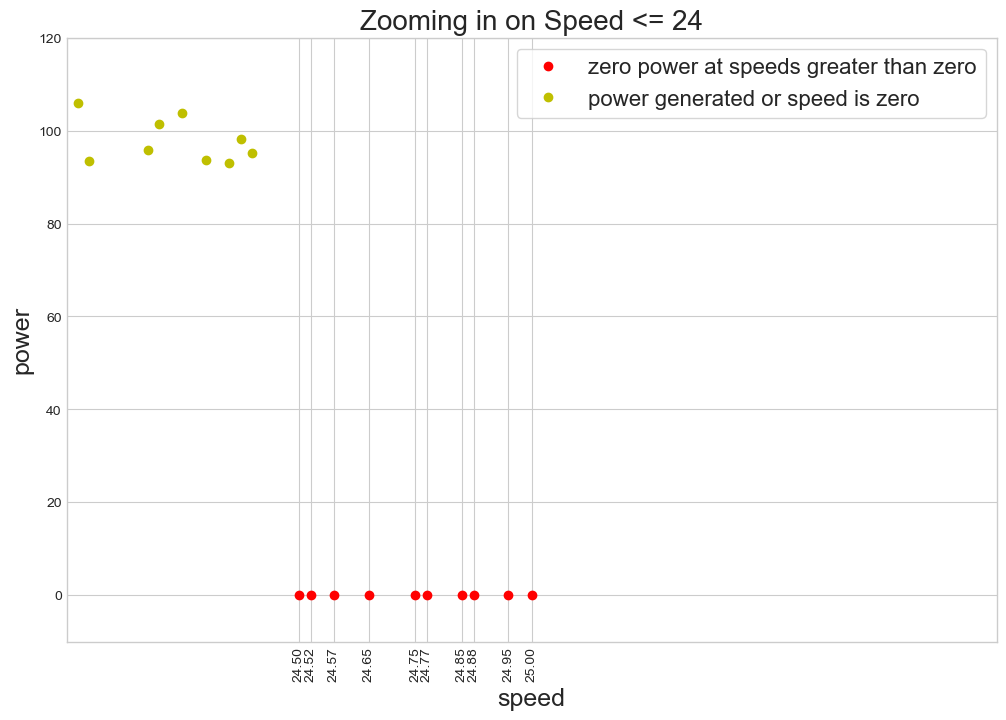

In [23]:
# fix the zoom in 

#Selecting rows based on certain conditions
# Adapted from  https://stackoverflow.com/a/17071908/11250489 [15]
# example df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
# speed greater than zero but power less than or equal to 0
dfa= df.loc[(df['speed'] !=0) & (df['power'] == 0)]
dfb=  df.loc[((df['speed'] !=0) & (df['power'] >0))|(df['speed']==0)]
plt.plot(dfa['speed'], dfa['power'],  'ro', label='zero power at speeds greater than zero')
plt.plot(dfb['speed'], dfb['power'],  'yo', label= 'power generated or speed is zero ')
plt.xticks(dfa['speed'], rotation=90)
plt.xlabel('speed', fontsize = 18)
plt.ylabel('power', fontsize =18)
plt.title('Zooming in on Speed <= 24', fontsize = 20)
# Adapted from https://stackoverflow.com/questions/25540259/remove-or-adapt-border-of-frame-of-legend-using-matplotlib
plt.legend(fontsize = 16, frameon=True)
plt.xlim(24, 26)
plt.ylim(-10,120)
plt.show()

## Data Cleaning

Removing datapoints with zero power produced at speeds greater than speed 7.5.

In [26]:
# Adapated from https://stackoverflow.com/a/53436229/11250489 [15]
# removing data where wind speeds are greater than or equal to 7.5 AND power generated is equal to 0.
dfclean = df.loc[~((df['speed']>=7.5) &(df['power']==0))]
dfclean.count()

speed    486
power    486
dtype: int64

### View the Cleaned data 

Plotting the linear relationship between power and speed first for the original data and then the cleaned data and comparing side by side reveals little differnce as we have only excluded 14 data points. 

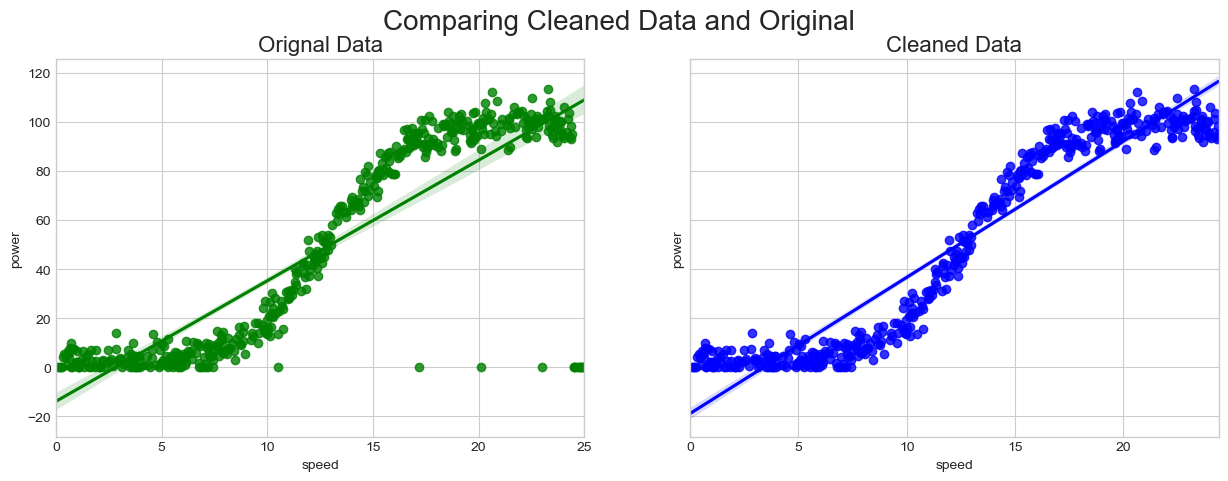

In [27]:

# https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8 [16]
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Comparing Cleaned Data and Original', fontsize = 20)
axes[0].set_title('Orignal Data', fontsize = 16)
sns.regplot(ax=axes[0],x=df['speed'], y=df['power'],color="g", data=df)
axes[1].set_title('Cleaned Data', fontsize = 16)
sns.regplot(ax=axes[1],x=dfclean['speed'], y=dfclean['power'], color="b",data=dfclean)

This is confirmed imposing one plot on top of another (ie viewing the original data and the cleaned data in the same subplot). The data cleansing process made little difference and may have been futile based on my decisions as to what was considered outliers. But is the a linear regression the correct tool to use anyway?

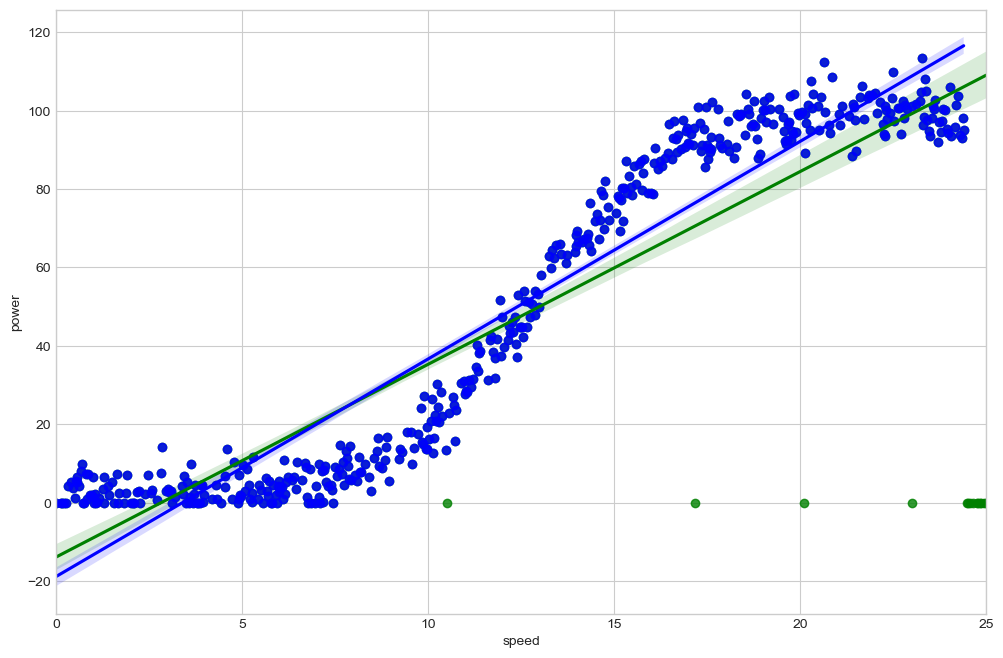

In [15]:
# https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8 [16]

sns.regplot(x=df['speed'], y=df['power'],color = "g", data=df)

sns.regplot(x=dfclean['speed'], y=dfclean['power'],color = "b", data=dfclean)


## MODELS

### Model 1 : Linear Regression

Firstly I will try to fit a linear model to the cleaned data.  I anticipdate a linear model might predict  power for speeds within the range 7.5 to 17.5 well enough perhaps as overall there appears some level of relationship between speed and power. Within that range though, 10 to 17.5, I would anticipate a strong linear relationship. However, the model I would think be inadequate for speed values < 7.5 where the relationshop appears more erratic. Also for speed values > 17 and < 24.5 the power generated levels off and so therefore a linear model would be less appropriate. However, I will start with a simple linear model to validate these assumptions. 

The Linear regression model essentially finds the best value for the intercept and slope, which results in a line that best fits the data. The equation for straight line is: $y = mx + b$.  b is the intercept and m is the slope of the line. The linear regression algorithm returns the optimal value for the intercept and the slope. There can be multiple straight lines dependent on the values of intercept and slope. The linear regression algorithm fits multiple lines on the data points and returns the line that results in the least error [3].



In [88]:
# Adapted from : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html [17]
#https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
# extra []ensuring that we end up with 2d array see https://stackoverflow.com/q/51150153
X = dfclean[["speed"]] 
y = dfclean["power"]
# print(X.dtype)

In [30]:
# Setting the test size = 0.2 using a random state to perserve outputs. 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state = 40)

In [31]:
# review the number of observations in each set.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(291, 1)
(195, 1)
(291,)
(195,)


In [32]:
# Create linear regression object reg
reg = linear_model.LinearRegression()

In [33]:
# Adapted from : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.htm [17]
#fit the inputs and outputs to the object
reg.fit(X_train,y_train)

LinearRegression()

In [21]:
# y = mx + b
# Where b is the intercept and m (coefficient)is the slope of the line. 

In [34]:
print("The optimal intercept value returned is ", reg.intercept_)

The optimal intercept value returned is  -19.568053773700193


In [35]:
print("The optimal slope value (coefficient) returned is ", reg.coef_)

The optimal slope value (coefficient) returned is  [5.60807048]


This means that for every one unit of change in speed, the predicted change in the power generated is about 9.91%.

In [36]:
# The y_pred is a numpy array that contains all the predicted values for the input values in the X_test series.
y_pred = reg.predict(X_test)


In [64]:
# save the model for use in the web app later.
# joblib.dump(reg, "models/linearreg.pkl")

['models/linearreg.pkl']

### Evalution Model 1 Results.

In [37]:
# Test on a single speed

test = 12.08
 
p = reg.predict([[test]])
p

array([48.17743758])

In [27]:
# # create a df to hold actuals and predicted.

# dflineareval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# dflineareval

,Actual,Predicted
452,102.544,108.144535
169,6.656,27.584603
377,87.986,86.250628
381,102.364,87.232040
268,63.383,56.499814
...,...,...
28,1.208,-13.113165
368,93.769,84.287803
162,5.696,24.920769
39,0.000,-9.322109


Mean Absolute Error (MAE) is the mean of the absolute value of the errors. 

In [28]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 11.915778527929977


Mean Squared Error (MSE) is the mean of the squared errors and is calculated as:

In [29]:
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Squared Error: 183.21474782528202


Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:

In [30]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Root Mean Squared Error: 13.535684239272207


In [31]:
r2 = metrics.r2_score(y_test,y_pred)
r2

0.894167628582804

You can see that the value of root mean squared error is significantly greater than 10% of the mean value of the power generated in the test set 12.715116.  This means that the model was not very accurate and an over simplified algorithm for this dataset. 

### Plot the results 

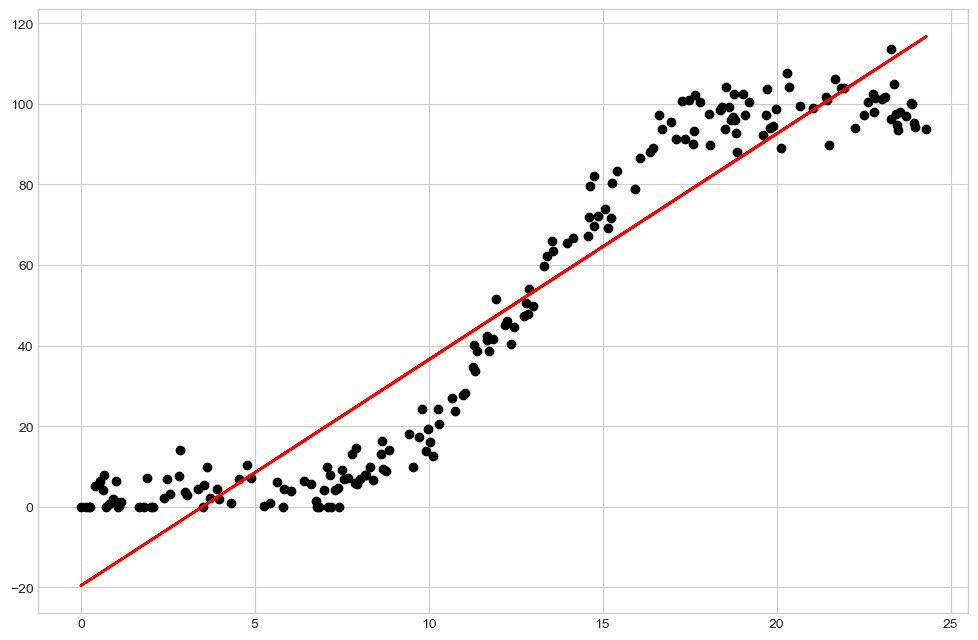

In [38]:
plt.scatter(X_test, y_test,  color='black') #plot scatters
plt.plot(X_test, y_pred, color='red', linewidth=2) #plot line

plt.show()

Again, the results show the alogrithm is unsuitable. The model is underfitting: proofing too inflexible and not accounting for the data being unable to capture patterns in the data. To overcome the problem of under-fitting, the complexity of the model needs to increased [6].



### Model 2 : Polynomial Regression.

A Polynominal Model is a special case of a linear model and can be used to fit a nonlinear data [5]. A straightforward way to do this is to add powers of each feature as new features [5].  Then, train a linear model on this extended set of features[5]. 

### Degrees = 2

So to begin the number of degrees will be set to 2. As to generate a higher order equation add powers of the original features as new features. The linear model: 
$$y = \theta_0 + \theta_1 x $$

can then be transformed to:

$$ y = \theta_0 + \theta_1 x + \theta_2 x^2$$ 

This is still a linear model as the coefficients associated with the features are still linear. x² is only a feature. But the curve being fitted is quadratic in nature [6]

In [39]:
# Adapted from : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html [18]
# Adapted from https://towardsdatascience.com/polynomial-regression-with-a-machine-learning-pipeline-7e27d2dedc87 [19]


In [34]:
# Setting the test size = 0.2 using a random state to perserve outputs. 
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 40)

In [40]:
# set the polynominal degrees to be 2
polyfeatures = PolynomialFeatures(degree=2, include_bias=False)
# create new features for the training data i.e. powers of x (adding a new variable x powered)
X_train_p =polyfeatures.fit_transform(X_train)

In [41]:
# Create a new linear model
polyreg = linear_model.LinearRegression()
# Train the model using the new dataset 
polyreg.fit(X_train_p, y_train)

# now create new features for the test data
X_test_p =polyfeatures.fit_transform(X_test)

# predict new y values for test data.
y_pred_p = polyreg.predict(X_test_p)


X_test_p.shape

(195, 2)

In [42]:
# Test on a single speed

test = 12.08
# dont have the transform function in the app so will have to manually add the x^2.
test2 = test**2
p = polyreg.predict([[test, test2]])
p

array([46.96465046])

### Plot the result

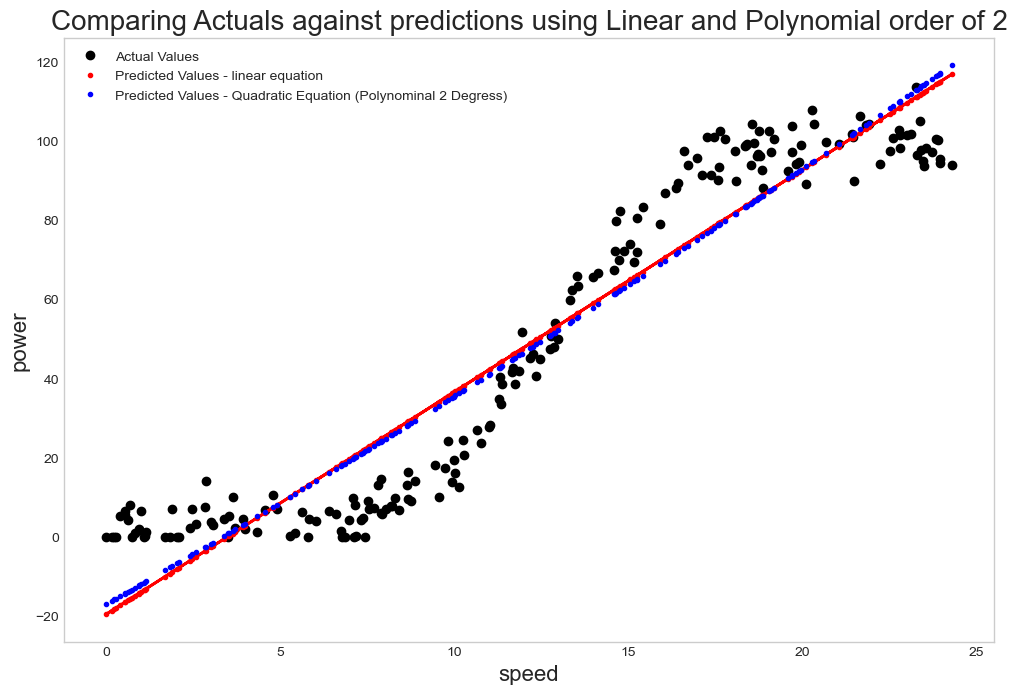

In [43]:
# Adapted from https://stackoverflow.com/questions/46096347/plot-polynomial-regression-in-python-with-scikit-learn [18]
# plt.plot(dfclean['speed'], dfclean['power'],  'og', label="cleaned data")
# plt.scatter(X_test, y_test,  color='black') #plot scatters
# plt.plot(X_test_p, y_pred_p, color='red', linewidth=2) #plot line


plt.plot(X_test, y_test, 'ok', label="Actual Values") 
plt.plot(X_test, y_pred, color='red', linewidth=2) #plot line
plt.plot(X_test, y_pred, '.r', label = "Predicted Values - linear equation") 
plt.plot(X_test, y_pred_p, '.b', label = "Predicted Values - Quadratic Equation (Polynominal 2 Degress)")
plt.xlabel('speed', fontsize='16')
plt.ylabel('power', fontsize='16')
plt.title("Comparing Actuals against predictions using Linear and Polynomial order of 2", fontsize = 20)
plt.grid()
plt.legend()
plt.show()



### Evaluate the result

It is quite clear visually from the plot that the quadratic curve (polynominal with degrees = 2) is not able to fit the data much better than the linear line. 

In [44]:
rmse_linear = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
rmse_poly_d2 = np.sqrt(metrics.mean_squared_error(y_test,y_pred_p))
r2_linear = metrics.r2_score(y_test,y_pred)
r2_poly_d2 = metrics.r2_score(y_test,y_pred_p)
print("RMSE value for linear equation: ", rmse_linear)
print("RMSE value using Polynomial with degrees = 2: ",rmse_poly_d2  )
print("R2 Value using linear equation: ", r2_linear)
print("R2 Value using polynominal equation with degrees = 2: ", r2_poly_d2)

RMSE value for linear equation:  13.535684239272207
RMSE value using Polynomial with degrees = 2:  13.323283754748529
R2 Value using linear equation:  0.894167628582804
R2 Value using polynominal equation with degrees = 2:  0.8974629890185972


We can see that RMSE has decreased but the R²score has increased as compared to the linear line. We need an improvement in both ***metrics***

In [63]:
# save the model to the models file for use later in the web app.
# joblib.dump(polyreg, "models/polyreg.pkl")

['models/polyreg.pkl']

### Model 2 : Polynomial Regression with 3 degrees.

The next step is to try a cubic curve (degree=3) by powering up our existing equation(quadatric)[6]:

$$ y = \theta_0 + \theta_1 x + \theta_2 x^2  + \theta_3x^3$$ 


In [46]:
# set the polynominal degrees to be 3
polyfeatures3 = PolynomialFeatures(degree=3, include_bias=False)
# create new features for the training data i.e. adding new variables to create a cubic equation.
X_train_p3 =polyfeatures3.fit_transform(X_train)

In [47]:
# Create a new cubic model
polyreg3 = linear_model.LinearRegression()
# Train the model using the new dataset 
polyreg3.fit(X_train_p3, y_train)

# now create new features for the test data
X_test_p3 =polyfeatures3.fit_transform(X_test)

# predict new y values for test data.
y_pred_p3 = polyreg3.predict(X_test_p3)

### Plot the result

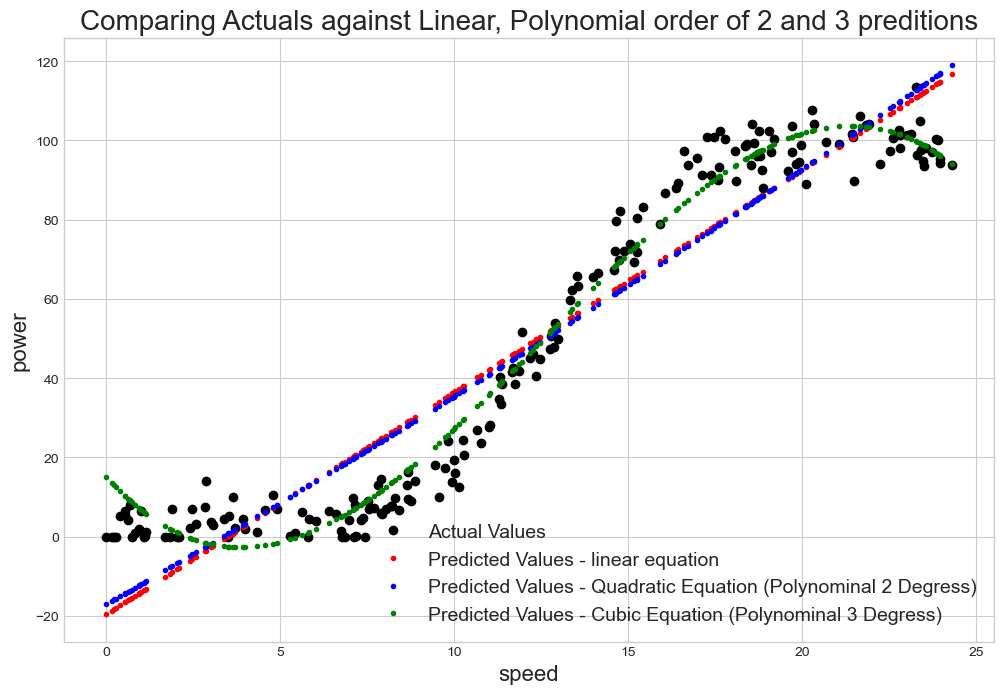

In [81]:
# plot the results & compare

plt.plot(X_test, y_test, 'ok', label="Actual Values") 
plt.plot(X_test, y_pred, '.r', label = "Predicted Values - linear equation") 
plt.plot(X_test, y_pred_p, '.b', label = "Predicted Values - Quadratic Equation (Polynominal 2 Degress)")
plt.plot(X_test, y_pred_p3, '.g', label = "Predicted Values - Cubic Equation (Polynominal 3 Degress)")
plt.xlabel('speed', fontsize='16')
plt.ylabel('power', fontsize='16')
plt.title("Comparing Actuals against Linear, Polynomial order of 2 and 3 preditions", fontsize = 20)
plt.grid()
plt.legend(fontsize = 14)
plt.grid()
plt.show()

### Evaluate the result

The visulations shows that predicted values using a Cubic equation (Polynominal 3 Degrees) is a better model.

In [48]:
rmse_linear = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
rmse_poly_d2 = np.sqrt(metrics.mean_squared_error(y_test,y_pred_p))
rmse_poly_d3 = np.sqrt(metrics.mean_squared_error(y_test,y_pred_p3))
r2_linear = metrics.r2_score(y_test,y_pred)
r2_poly_d2 = metrics.r2_score(y_test,y_pred_p)
r2_poly_d3 = metrics.r2_score(y_test,y_pred_p3)
print("RMSE value for linear equation: ", rmse_linear)
print("RMSE value using Polynomial with degrees = 2: ",rmse_poly_d2)
print("RMSE value using Polynomial with degrees = 3: ",rmse_poly_d3)
print("R2 Value using linear equation: ", r2_linear)
print("R2 Value using polynominal equation with degrees = 2: ", r2_poly_d2)
print("R2 Value using polynominal equation with degrees = 3: ", r2_poly_d3)

RMSE value for linear equation:  13.535684239272207
RMSE value using Polynomial with degrees = 2:  13.323283754748529
RMSE value using Polynomial with degrees = 3:  6.19445728814166
R2 Value using linear equation:  0.894167628582804
R2 Value using polynominal equation with degrees = 2:  0.8974629890185972
R2 Value using polynominal equation with degrees = 3:  0.9778351588100399


The RMSE when using a cubic equation has decreased for polynominal with degrees = 3 and the R²-score has increased as compared to the linear line results. Therefore Polynominal model with degrees = 3 is the best fit so far. 

However, **there is a persistant problem with predictions for wind speeds below 5 in particular**. While the linear model and polynominal model with degrees = 2 tend to go negative, the polynominal model with 3 degrees tends to firstly underestimate the power generated for wind speeds just less than 5 and then overestimate the power generated as wind values approach closer to zero. 

## Two Problems

1. How many dregrees should I use in a polynomial equation? Should I keep increasing the number of degrees further?  
2. Should the data points where speed > 24.5 be included in the model? (I went back and excluded these values after implementing Keras and seeing that none of the models implemented could adequately cope with wind values greater than 24.5.  The index.html will have to exclude such values as the models will be distorted with the inclusion of same).
3. Still the problem of values wind speed of 5 and less needs to be addressed.

## Deciding upon the optimum number of degrees to use. 

In [51]:
# Creating a function to apply create a polynominal equation based on nth number of dregrees 

def polynomialmodel(n):
    # set the polynominal degrees to be n
    polyfeaturesn = PolynomialFeatures(degree=n, include_bias=False)
# create new features for the training data i.e. adding new variables to create a cubic equation.
    X_train_pn =polyfeaturesn.fit_transform(X_train)
    # Create a new cubic model
    polyregn = linear_model.LinearRegression()
# Train the model using the new dataset 
    polyregn.fit(X_train_pn, y_train)

# now create new features for the test data
    X_test_pn =polyfeaturesn.fit_transform(X_test)

# predict new y values for test data.
    y_pred_pn = polyregn.predict(X_test_pn)
    rmse_poly_n = np.sqrt(metrics.mean_squared_error(y_test,y_pred_pn))
    r2_poly_n = metrics.r2_score(y_test,y_pred_pn)
    print(f'For {n} degrees the RMSE is {np.sqrt(metrics.mean_squared_error(y_test,y_pred_pn))}')
    print(f'For {n} degrees the R2 is {metrics.r2_score(y_test,y_pred_pn)}')
    return n, rmse_poly_n, r2_poly_n
    
    
    

In [52]:
# Compare the RMSE and R2 results for each model with degrees from 2 to 8
 
for i in range(2,10):
    polynomialmodel(i)
    

For 2 degrees the RMSE is 13.323283754748529
For 2 degrees the R2 is 0.8974629890185972
For 3 degrees the RMSE is 6.19445728814166
For 3 degrees the R2 is 0.9778351588100399
For 4 degrees the RMSE is 5.905475989967316
For 4 degrees the R2 is 0.9798549701755479
For 5 degrees the RMSE is 4.3784347453578665
For 5 degrees the R2 is 0.9889262207589685
For 6 degrees the RMSE is 4.379767202166241
For 6 degrees the R2 is 0.9889194797299966
For 7 degrees the RMSE is 4.265078430468941
For 7 degrees the R2 is 0.9894921916768121
For 8 degrees the RMSE is 4.231203629684707
For 8 degrees the R2 is 0.9896584424868307
For 9 degrees the RMSE is 4.3069289783782425
For 9 degrees the R2 is 0.989284966850481


Under-fitting / Over-fitting
Under-fitting occurs when the model cannot adequately capture the underlying structure of the data (as seen in the linear model above and polynominal with degree = 2).
In contrast, over-fitting produces an analysis that corresponds too closely to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably [6]. At this point, I am unsure what is the optimal degrees to use. Degrees = 3 is definitely better than degrees = 2 since for degrees = 3 the RMSE value is lower and the R2 value is higher. As the number of degrees is raised further the RMSE and R2 results do not significantly change until number of degrees applied is 7.  I then worry that we are overfitting the data. 

In order to move on in this task, I will then use number of degrees = 3 for the polynominal model. However, regardless of degrees I am not satified with how the very low speeds ie < 5 are predicted using a polynominal model. I will try to implement a Keras model and hope for improved accuracy overall but in particular in relation to very low wind speeds.

In [62]:
# # save the model to the models file for use later in the web app.
# joblib.dump(polyreg3, "models/polyreg3.pkl")

['models/polyreg3.pkl']

## Model 3: Keras

Deep learning refers to artificial neural networks with multiple hidden layers that can learn increasingly abstract representations of input data [12]. Artificial neural networks are a technology based on studies of the brain and nervous system[11]. An Artificial neural network is founded on a collection of connected units or nodes which are called artificial neurons. These neurons are broadly modelled on the neurons in a biological brain [12].  

Similar to the the synapses in a biological brain, each connection can send a signal to other neurons[12]. The signal is a real number, and the output of each neuron is calculated by a non-linear function of the sum of its inputs [12]. The connections are called edges and both the neurons and the edges usualy have a weight associated with them which adjusts as learning progresses. These weights influence the strength of the signal at a connection [11, 12]. Neurons can have a threshold set so that a signal is not fired unless the threshold is met [11].

Neurons are usually aggregated into hidden layers[11]. Different layers can carry out different transformations on the input they receive. Signals transmit from the input layer to the output layer after possibly travelling through the layers multiple times[11].


For this task, a neural netwwork with a sequential model will be used as it is most appropriate for simple layers where each layer has exactly one input tensor and one output tensor [7]. It involves defining a Sequential class and then adding layers to the model one by one ,from input to output [8]. In the model below,  Sequential constructor is used to create a model, which will then have layers added to it using the add() method. The first such call adds a layer of type Dense . The Dense layer has an output of size (50 in the case of the first layer added below), and an input of shape of one dimension. The number of epochs determine the number of times each wind value loops through neural network. As the number of completed ephochs increases the accuracy of the model should increase and the 'loss' (set to be measured as mean squared error in this model) should decrease. 

In [76]:
# Create a new neural network.
model = keras.models.Sequential()
# adding two layers 
# one input tensor but with 50 hidden layers.
# the input shape (depth, width, height) of each input in this case a I demonsional variable.
# using activiation sigmoid as the sigmoid shape most closely aligns with the data set.
# using kernel
model.add(keras.layers.Dense(50, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# adding another layer single density but with activiation linear to cope with any 0
model.add(keras.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
# using Adam optimizer but adding a learning rate of 0.001 to Adam so that it doesnt train too quickly
# loss measurement "mean_squared_error" to be recorded as the loss type measurement.
model.compile(keras.optimizers.Adam(lr=0.001), loss='mean_squared_error')
# print the model summary.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


The first Dense layer has 50 neurons plus 50 bias terms = 100 parameters for this layer. The second Dense layer has output layer with 1 neuron with bias of 1 and 50 inputs feeding to it, = 51 parameters. The complete neural network then 151 parameters.

In [77]:
# the number of epochs (the number of times each wind value loops through neural network) 
# the batch size (number of samples in an epoch used to estimate model error).

# batch size is set to 10 to evaluate 10 values at a time
fithistory = model.fit(X_train, y_train, batch_size=10, epochs=500)

Epoch 1/500
30/30 [==============================] - 1s 2ms/step - loss: 4367.2653
Epoch 2/500
30/30 [==============================] - 0s 2ms/step - loss: 3996.2512
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 3886.4095
Epoch 4/500
30/30 [==============================] - 0s 2ms/step - loss: 4024.8186
Epoch 5/500
30/30 [==============================] - 0s 2ms/step - loss: 3946.4091
Epoch 6/500
30/30 [==============================] - 0s 2ms/step - loss: 3895.6404
Epoch 7/500
30/30 [==============================] - 0s 2ms/step - loss: 3337.1843
Epoch 8/500
30/30 [==============================] - 0s 3ms/step - loss: 3449.5687
Epoch 9/500
30/30 [==============================] - 0s 3ms/step - loss: 3003.9947
Epoch 10/500
30/30 [==============================] - 0s 2ms/step - loss: 2887.1679
Epoch 11/500
30/30 [==============================] - 0s 3ms/step - loss: 2675.3874
Epoch 12/500
30/30 [==============================] - 0s 2ms/step - loss: 3115.2036
E

30/30 [==============================] - 0s 2ms/step - loss: 342.3497
Epoch 100/500
30/30 [==============================] - 0s 2ms/step - loss: 330.4111
Epoch 101/500
30/30 [==============================] - 0s 1ms/step - loss: 297.2306
Epoch 102/500
30/30 [==============================] - 0s 1ms/step - loss: 297.7594
Epoch 103/500
30/30 [==============================] - 0s 2ms/step - loss: 303.4269
Epoch 104/500
30/30 [==============================] - 0s 2ms/step - loss: 278.1745
Epoch 105/500
30/30 [==============================] - 0s 2ms/step - loss: 282.5693
Epoch 106/500
30/30 [==============================] - 0s 2ms/step - loss: 261.5064
Epoch 107/500
30/30 [==============================] - 0s 2ms/step - loss: 251.0796
Epoch 108/500
30/30 [==============================] - 0s 2ms/step - loss: 253.5729
Epoch 109/500
30/30 [==============================] - 0s 2ms/step - loss: 262.7264
Epoch 110/500
30/30 [==============================] - 0s 2ms/step - loss: 235.0826
Epoch 

30/30 [==============================] - 0s 4ms/step - loss: 68.0632
Epoch 197/500
30/30 [==============================] - 0s 2ms/step - loss: 72.7704
Epoch 198/500
30/30 [==============================] - 0s 2ms/step - loss: 69.6656
Epoch 199/500
30/30 [==============================] - 0s 4ms/step - loss: 65.8613
Epoch 200/500
30/30 [==============================] - ETA: 0s - loss: 70.64 - 0s 2ms/step - loss: 70.0762
Epoch 201/500
30/30 [==============================] - 0s 1ms/step - loss: 66.0320
Epoch 202/500
30/30 [==============================] - 0s 2ms/step - loss: 71.2046
Epoch 203/500
30/30 [==============================] - 0s 2ms/step - loss: 62.7671
Epoch 204/500
30/30 [==============================] - 0s 3ms/step - loss: 63.5429
Epoch 205/500
30/30 [==============================] - 0s 4ms/step - loss: 70.1389
Epoch 206/500
30/30 [==============================] - 0s 2ms/step - loss: 70.5243
Epoch 207/500
30/30 [==============================] - 0s 2ms/step - loss: 57

30/30 [==============================] - 0s 2ms/step - loss: 49.3055
Epoch 295/500
30/30 [==============================] - 0s 1ms/step - loss: 51.0823
Epoch 296/500
30/30 [==============================] - 0s 2ms/step - loss: 48.6915
Epoch 297/500
30/30 [==============================] - 0s 1ms/step - loss: 44.3255
Epoch 298/500
30/30 [==============================] - 0s 1ms/step - loss: 43.8907
Epoch 299/500
30/30 [==============================] - 0s 1ms/step - loss: 41.2505
Epoch 300/500
30/30 [==============================] - 0s 1ms/step - loss: 44.1579
Epoch 301/500
30/30 [==============================] - 0s 1ms/step - loss: 39.1141
Epoch 302/500
30/30 [==============================] - 0s 1ms/step - loss: 40.0849
Epoch 303/500
30/30 [==============================] - 0s 2ms/step - loss: 42.7885
Epoch 304/500
30/30 [==============================] - 0s 1ms/step - loss: 39.2069
Epoch 305/500
30/30 [==============================] - 0s 2ms/step - loss: 46.4646
Epoch 306/500
30/3

30/30 [==============================] - 0s 5ms/step - loss: 29.6684
Epoch 393/500
30/30 [==============================] - 0s 5ms/step - loss: 30.8866
Epoch 394/500
30/30 [==============================] - 0s 3ms/step - loss: 25.5784
Epoch 395/500
30/30 [==============================] - 0s 1ms/step - loss: 31.1624
Epoch 396/500
30/30 [==============================] - 0s 2ms/step - loss: 30.2695
Epoch 397/500
30/30 [==============================] - 0s 1ms/step - loss: 27.6893
Epoch 398/500
30/30 [==============================] - 0s 1ms/step - loss: 31.9664
Epoch 399/500
30/30 [==============================] - 0s 2ms/step - loss: 27.7890
Epoch 400/500
30/30 [==============================] - 0s 2ms/step - loss: 29.9505
Epoch 401/500
30/30 [==============================] - 0s 2ms/step - loss: 32.1492
Epoch 402/500
30/30 [==============================] - 0s 3ms/step - loss: 28.5325
Epoch 403/500
30/30 [==============================] - 0s 3ms/step - loss: 25.1357
Epoch 404/500
30/3

30/30 [==============================] - 0s 2ms/step - loss: 23.2063
Epoch 491/500
30/30 [==============================] - 0s 2ms/step - loss: 22.7731
Epoch 492/500
30/30 [==============================] - 0s 1ms/step - loss: 21.5019
Epoch 493/500
30/30 [==============================] - 0s 1ms/step - loss: 22.1082
Epoch 494/500
30/30 [==============================] - 0s 1ms/step - loss: 19.1059
Epoch 495/500
30/30 [==============================] - 0s 1ms/step - loss: 19.8943
Epoch 496/500
30/30 [==============================] - 0s 1ms/step - loss: 21.4886
Epoch 497/500
30/30 [==============================] - 0s 1ms/step - loss: 22.5689
Epoch 498/500
30/30 [==============================] - 0s 1ms/step - loss: 23.0809
Epoch 499/500
30/30 [==============================] - 0s 2ms/step - loss: 20.1221
Epoch 500/500
30/30 [==============================] - 0s 1ms/step - loss: 22.0780


### Plot the results

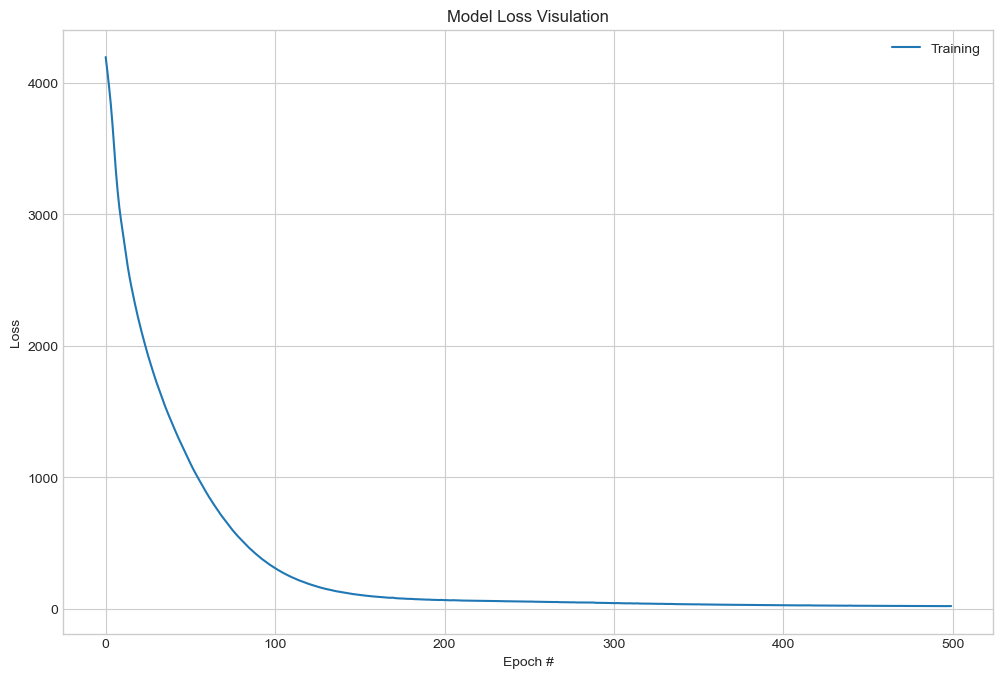

In [82]:
# As the model continues to fit the loss should decrease as the number of epochs completed rises 
# i.e. the accuracy of the model learnings improves.
# Plot training loss for each epoch

plt.plot(fithistory.history['loss'])
plt.title('Model Loss Visulation')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['Training', 'Valuation/Test'])
plt.show()


###  Predict the test set using Keras model

In [83]:
y_pred_k = model.predict(X_test)

<function matplotlib.pyplot.show(*args, **kw)>

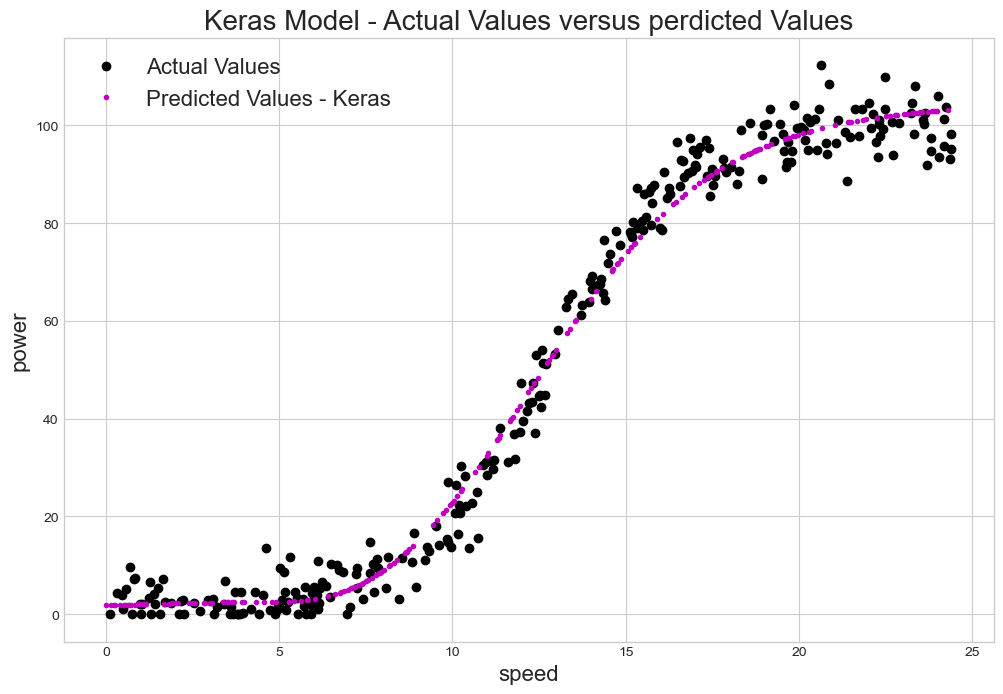

In [84]:
# plot the trained values versus the predicted values.
plt.plot(X_train, y_train, 'ok', label="Actual Values") 
plt.plot(X_test, y_pred_k, '.m', label = "Predicted Values - Keras")
plt.title("Keras Model - Actual Values versus perdicted Values", fontsize = 20)
plt.xlabel('speed', fontsize='16')
plt.ylabel('power', fontsize='16')
plt.legend(fontsize = 16)
plt.show


In [61]:
# # # save the model to the models file for use later in the web app.
# filename = 'kerasmodel.sav'
# joblib.dump(model, filename)
# This failed for some reason with type error: TypeError: cannot pickle 'weakref' object
# Adapted from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/[10]
# model.save("models/kerasmodel.h5")



### Calculate R2 value for Keras (Unable to do so.)

In [106]:
# https://stackoverflow.com/questions/56688744/unable-to-import-metric-from-tensorflow-keras-metrics [20]
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/RSquare [21]
# r2_keras = Metric.metrics.RSquare()
# r2_keras.update_state(y_test, y_pred_k)
# print('R^2 score is: ', r1.result().numpy()) # 0.57142866
# I was unable to get Rsquare value for keras.

### Evaluate the result

We can see from above "Model Loss Visualization" that the loss (mean squared error) recorded at completion of the first epoch was 4367.2653 and this loss continued to go on a downward trajectory (overall) until it began to plateua approximately from epoch 430 onward and by the last epoch the loss was recorded as mean squared error of 22.0780.

Visualation "Keras Model - Actual Values versus perdicted Values" shows how this model predicted power generated versus actual power generated at various wind speeds for the test test. We can see there is an improvement in how speed values less than 5 are predicted by Keras in comparison to the other models.


# Summary : Comparing all four models 

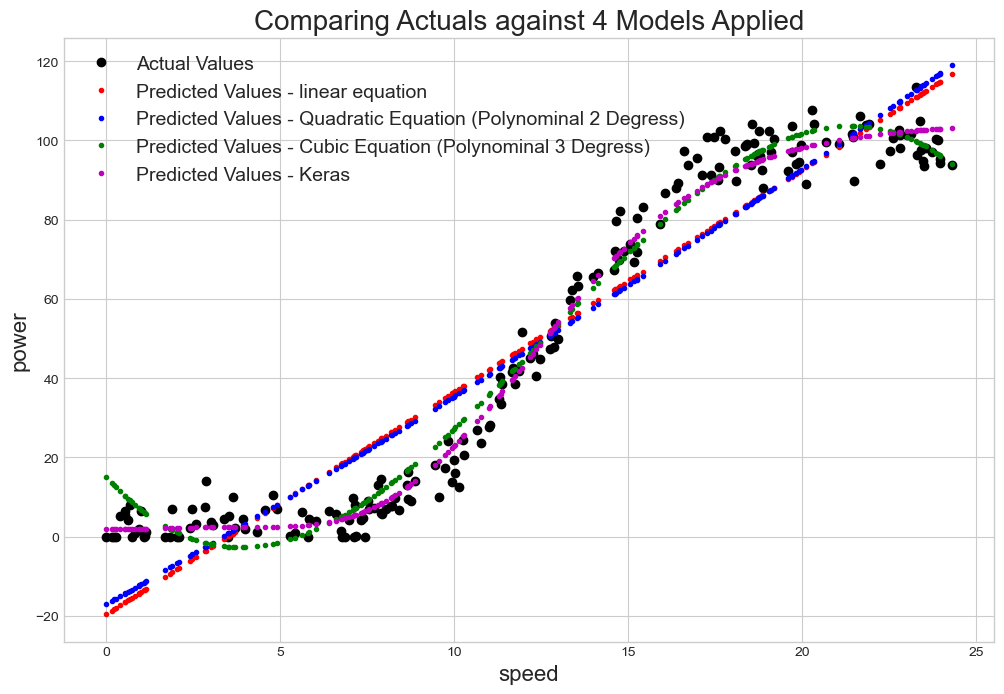

In [85]:
plt.plot(X_test, y_test, 'ok', label="Actual Values") 
plt.plot(X_test, y_pred, '.r', label = "Predicted Values - linear equation") 
plt.plot(X_test, y_pred_p, '.b', label = "Predicted Values - Quadratic Equation (Polynominal 2 Degress)")
plt.plot(X_test, y_pred_p3, '.g', label = "Predicted Values - Cubic Equation (Polynominal 3 Degress)")
plt.plot(X_test, y_pred_k, '.m', label = "Predicted Values - Keras")
plt.xlabel('speed', fontsize='16')
plt.ylabel('power', fontsize='16')
plt.title("Comparing Actuals against 4 Models Applied", fontsize = 20)
plt.grid()
plt.legend(fontsize = 14)
plt.grid()
plt.show()

Visualization "Comparing Actuals against 4 Models Applied" clearly shows that the third model, Polynomial with 3 Degrees, is a definite improvement on the the linear model and Polynomial with just 2 degrees. The Polynominal with 3 Degrees predictions are clearly closer to the actual predictions. However this model is not as accurate as the final model, Keras which appears from the visualization to more accurately predict power generated when wind speed values of 5 or less are encountered. 

However Keras still has some shortcomings for these low wind speeds, when wind speed is actually zero Keras does seem to overpredict ie not predict zero power generated. I am unclear about where the line between overfiting occurs and inadequate predictions.

Finally, none of the models employed could include wind values greater than 24.5. There was limited data with wind speeds 24.5. But, all of the power generated values where zero for speed >= 24.5.  When I included these wind speed values in model training the predicted results where skwewed for higher wind speeds so I decided to exclude all wind speed >= 24.5 and limit the model to predicting wind speeds of less than 24.5. I am not sure this is right approach and this may well be a major weakness in this project approach.

In [86]:
rmse_linear = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
rmse_poly_d2 = np.sqrt(metrics.mean_squared_error(y_test,y_pred_p))
rmse_poly_d3 = np.sqrt(metrics.mean_squared_error(y_test,y_pred_p3))
rmse_keras = np.sqrt(fithistory.history['loss'][499])
r2_linear = metrics.r2_score(y_test,y_pred)
r2_poly_d2 = metrics.r2_score(y_test,y_pred_p)
r = metrics.r2_score(y_test,y_pred_p3)
print("RMSE value for linear equation: ", rmse_linear)
print("RMSE value using Polynomial with degrees = 2: ",rmse_poly_d2)
print("RMSE value using Polynomial with degrees = 3: ",rmse_poly_d3)
print("RMSE value using Keras", rmse_keras)
print("R2 Value using linear equation: ", r2_linear)
print("R2 Value using polynominal equation with degrees = 2: ", r2_poly_d2)
print("R2 Value using polynominal equation with degrees = 3: ", r2_poly_d3)

RMSE value for linear equation:  13.535684239272207
RMSE value using Polynomial with degrees = 2:  13.323283754748529
RMSE value using Polynomial with degrees = 3:  6.19445728814166
RMSE value using Keras 4.661322985625257
R2 Value using linear equation:  0.894167628582804
R2 Value using polynominal equation with degrees = 2:  0.8974629890185972
R2 Value using polynominal equation with degrees = 3:  0.9778351588100399


As we can see the RMSE value when comparing the test set actual power generated against predicted power is best for Keras. Again, the Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors. Sadly, I failed to figure out how to get the R2 value for the keras model.

## References

[1] https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm    
[2] Kotu, V., & Deshpande, B., "Anomaly Detection", Science Direct https://www.sciencedirect.com/topics/computer-science/anomaly-detection  
[3] Robinson, S. "Linear Regression in Python with Scikit-Learn", Stack Abuse https://stackabuse.com/linear-regression-in-python-with-scikit-learn/  
[4] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html  
[5] Pramoditha, R, "Polynomial Regression with a Machine Learning", Towards DataScience, https://towardsdatascience.com/polynomial-regression-with-a-machine-learning-pipeline-7e27d2dedc87  
[6] Agarwal A., 2018, "Polynomial Regression" Towards Data Science, https://towardsdatascience.com/polynomial-regression-bbe8b9d97491  
[7] Chollet F., "Developer guides / The Sequential model", Keras, https://keras.io/guides/sequential_model/   
[8] Brownlee, J. 2019"TensorFlow 2 Tutorial: Get Started in Deep Learning With tf.keras", Machine Learning Mastery, https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/  
[9] Brownlee, J. 2019, Save and Load Machine Learning Models in Python with scikit-learn, Machine Learning Mastery https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/  
[10] Brownlee, J. "How to Save and Load Your Keras Deep Learning Model", Machine Learning Mastery,
https://machinelearningmastery.com/save-load-keras-deep-learning-models/  
[11] Walczaka, S and Cerpab, N.,"Artificial Neural Networks", Encyclopedia of Physical Science and Technology (Third Edition)
2003, Pages 631-645 https://doi.org/10.1016/B0-12-227410-5/00837-1  
[12]Wikipedia, "Artificial neural network', Wikipedia,https://en.wikipedia.org/wiki/Artificial_neural_network
[13] Aurora0001, "Purpose of '%matplotlib inline'", Stack Overflow, https://stackoverflow.com/q/43027980  
[14] unutbu, "How to select rows from a DataFrame based on column values", Stack Overflow, https://stackoverflow.com/a/17071908/11250489  
[15] Saurabh, Reply to "Drop rows on multiple conditions in pandas dataframe', Stack Overflow, 
https://stackoverflow.com/a/53436229/11250489  
[16] Bruno, T."Subplotting with matplotlib and seaborn", Seaborn Multiple Plots, Dev.to https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8  
[17] Scikit Learn, "sklearn.linear_model.LinearRegression", Scikit.learn.org, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  
[18] Scikit Learn, "sklearn.preprocessing.PolynomialFeatures", Scikit.learn.org https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
[19] Pramoditha, R., "Regression with a Machine Learning Pipeline", Towards Data Science, https://towardsdatascience.com/polynomial-regression-with-a-machine-learning-pipeline-7e27d2dedc87  
[20] Kumar, P., "unable to import Metric from tensorflow.keras.metrics", Stack OverFlow, https://stackoverflow.com/questions/56688744/unable-to-import-metric-from-tensorflow-keras-metrics
[21] TensorFlow "tfa.metrics.RSquare",TensorFlow Resources https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/RSquare
